In [198]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity

In [246]:
# Use standard FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

In [247]:
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

    self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)

  # define forward function
  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # conv 2
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # fc1
    t = t.reshape(-1, 12*4*4)
    t = self.fc1(t)
    t = F.relu(t)

    # fc2
    t = self.fc2(t)
    t = F.relu(t)

    # output
    t = self.out(t)
    # don't need softmax here since we'll use cross-entropy as activation.

    return t

In [248]:
from collections import OrderedDict

# put all hyper params into a OrderedDict, easily expandable
params = OrderedDict(
    lr = [.01],
    batch_size = [100],
    shuffle = [False]
)
epochs = 10

In [249]:
# import modules to build RunBuilder and RunManager helper classes
from collections import namedtuple
from itertools import product

# Read in the hyper-parameters and return a Run namedtuple containing all the 
# combinations of hyper-parameters
class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

In [250]:
# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.network = None
    self.loader = None
    self.tb = None

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, run, network, loader):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network
    self.loader = loader
    self.tb = SummaryWriter(comment=f'-{run}')

    images, labels = next(iter(self.loader))
    grid = torchvision.utils.make_grid(images)

    self.tb.add_image('images', grid)
    self.tb.add_graph(self.network, images)

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.tb.close()
    self.epoch_count = 0

  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0

  # 
  def end_epoch(self):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)

    # Record epoch loss and accuracy to TensorBoard 
    self.tb.add_scalar('Loss', loss, self.epoch_count)
    self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

    # Record params to TensorBoard
    for name, param in self.network.named_parameters():
      self.tb.add_histogram(name, param, self.epoch_count)
      self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    clear_output(wait=True)
    display(df)

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item() * self.loader.batch_size

  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
  
  # save end results of all runs into csv, json for further analysis
  def save(self, fileName):

    pd.DataFrame.from_dict(
        self.run_data, 
        orient = 'columns',
    ).to_csv(f'{fileName}.csv')

    with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
      json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [251]:
m = RunManager()

# get all runs from params using RunBuilder class
for run in RunBuilder.get_runs(params):

    # if params changes, following line of code should reflect the changes too
    network = Network()
    loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size)
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run, network, loader)
    for epoch in range(epochs):
      
      m.begin_epoch()
      for batch in loader:
        
        images = batch[0]
        labels = batch[1]
        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(preds, labels)

      m.end_epoch()
    m.end_run()

# when all runs are done, save results to files
m.save('results')

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,0.545659,0.794917,11.745786,11.903681,0.01,100,False
1,1,2,0.387330,0.856050,9.822685,21.827225,0.01,100,False
2,1,3,0.357752,0.866517,11.638314,33.592644,0.01,100,False
3,1,4,0.337304,0.874550,12.861645,46.612170,0.01,100,False
4,1,5,0.334217,0.877667,13.303794,60.109717,0.01,100,False
5,1,6,0.326837,0.878083,12.339510,72.568414,0.01,100,False
6,1,7,0.317808,0.882033,11.776830,84.530805,0.01,100,False
7,1,8,0.315728,0.882533,11.625902,96.341832,0.01,100,False
8,1,9,0.308057,0.884967,11.688294,108.177775,0.01,100,False
9,1,10,0.312149,0.884600,11.545153,119.891121,0.01,100,False


In [252]:
def get_pil_transform(): 
    transf = transforms.Compose([
        #transforms.Resize((28, 28)),
    ])    

    return transf

def get_preprocess_transform():
    transf = transforms.Compose([
        #transforms.Resize((28, 28)),
        transforms.ToTensor(),
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [306]:
def batch_predict(pred_images):
    pred_images = pred_images[:,:,:,0]
    batchy = torch.stack(tuple(preprocess_transform(i) for i in pred_images), dim=0)
    
    logits = network(batchy)
    probs = F.softmax(logits, dim=1)
    return probs.detach().numpy()

In [307]:
def batch_true_predict(pred_images):
    batchy = torch.stack(tuple(preprocess_transform(i) for i in pred_images), dim=0)
    
    logits = network(batchy)
    probs = F.softmax(logits, dim=1)
    return probs.detach().numpy()

In [308]:
test_dataloader      = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0)
imgs, lbls  = iter(test_dataloader).next()

img = torchvision.transforms.ToPILImage()(imgs[0])

tensor(9)


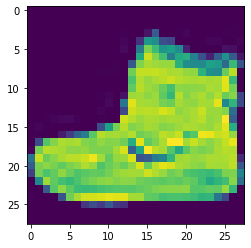

In [309]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(img)
print(lbls[0])

In [310]:
img

In [311]:
pix = np.array(img)
pix.shape

(28, 28)

In [355]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(pix, 
                                         batch_predict, # classification function
                                         #top_labels=5, 
                                         hide_color=0, 
                                         num_samples=10000) # number of images that will be sent to classification function

  0%|          | 0/10000 [00:00<?, ?it/s]

In [358]:
explanation.local_exp

{8: [(0, -0.0002411941253880075)],
 0: [(0, -1.0986109724796382e-05)],
 5: [(0, -0.6263060475352338)],
 7: [(0, 0.0001365226207833835)],
 9: [(0, 0.6274601539285981)]}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


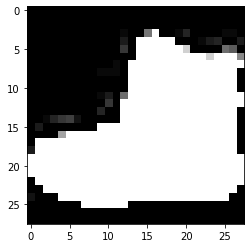

In [356]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/28, mask)
plt.imshow(img_boundry1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


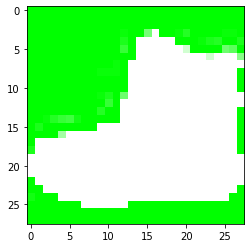

In [357]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/28, mask)
plt.imshow(img_boundry2)

In [313]:
sample_size = 1000
sample_lbls = []
sample_imgs = []

iterator = iter(torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0))

for i in range(samp_size):
    img, lbl  = next(iterator)
    img = torchvision.transforms.ToPILImage()(img[0])
    sample_lbls.append(lbl)
    sample_imgs.append(img)

In [314]:
img

In [316]:
true_preds = batch_true_predict(sample_imgs)

In [324]:
from tqdm import tqdm

lime_local_pred = []
lime_local_exp = []
lime_score = []
for im in tqdm(sample_imgs):
    exp = explainer.explain_instance(np.array(im), batch_predict)
    lime_local_pred.append(exp.local_pred)
    lime_local_exp.append(exp.local_exp)
    lime_score.append(exp.score)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<05:06,  3.26it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 2/1000 [00:00<05:30,  3.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<04:59,  3.33it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 4/1000 [00:01<04:40,  3.55it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 5/1000 [00:01<05:26,  3.05it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 6/1000 [00:02<06:33,  2.53it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 7/1000 [00:02<05:52,  2.82it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 8/1000 [00:02<05:26,  3.04it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 9/1000 [00:02<05:01,  3.28it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:03<04:46,  3.46it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 11/1000 [00:03<05:15,  3.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 12/1000 [00:03<05:34,  2.95it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|▏         | 13/1000 [00:04<06:11,  2.66it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|▏         | 14/1000 [00:04<05:37,  2.92it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▏         | 15/1000 [00:04<05:05,  3.22it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▏         | 16/1000 [00:05<04:33,  3.60it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▏         | 17/1000 [00:05<05:08,  3.19it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▏         | 18/1000 [00:05<05:48,  2.82it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▏         | 19/1000 [00:06<05:23,  3.04it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▏         | 20/1000 [00:06<05:07,  3.18it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▏         | 21/1000 [00:06<04:36,  3.55it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▏         | 22/1000 [00:06<04:14,  3.84it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▏         | 23/1000 [00:07<04:42,  3.46it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▏         | 24/1000 [00:07<05:51,  2.78it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▎         | 25/1000 [00:08<05:36,  2.90it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  3%|▎         | 26/1000 [00:08<04:55,  3.29it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  3%|▎         | 27/1000 [00:08<04:22,  3.70it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  3%|▎         | 28/1000 [00:08<04:00,  4.04it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  3%|▎         | 29/1000 [00:08<03:48,  4.25it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  3%|▎         | 30/1000 [00:09<03:36,  4.48it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  3%|▎         | 31/1000 [00:09<03:30,  4.61it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  3%|▎         | 32/1000 [00:09<03:30,  4.60it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  3%|▎         | 33/1000 [00:09<03:24,  4.72it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  3%|▎         | 34/1000 [00:09<03:24,  4.72it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  4%|▎         | 35/1000 [00:10<03:27,  4.64it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  4%|▎         | 36/1000 [00:10<03:25,  4.68it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  4%|▎         | 37/1000 [00:10<03:27,  4.65it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  4%|▍         | 38/1000 [00:10<03:24,  4.71it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  4%|▍         | 39/1000 [00:10<03:22,  4.74it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  4%|▍         | 40/1000 [00:11<03:16,  4.88it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  4%|▍         | 41/1000 [00:11<03:28,  4.61it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  4%|▍         | 42/1000 [00:11<03:25,  4.66it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  4%|▍         | 43/1000 [00:11<03:25,  4.65it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  4%|▍         | 44/1000 [00:12<03:27,  4.61it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  4%|▍         | 45/1000 [00:12<03:21,  4.74it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  5%|▍         | 46/1000 [00:12<03:17,  4.83it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  5%|▍         | 47/1000 [00:12<03:16,  4.84it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  5%|▍         | 48/1000 [00:12<03:12,  4.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  5%|▍         | 49/1000 [00:13<03:11,  4.96it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  5%|▌         | 50/1000 [00:13<03:09,  5.01it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  5%|▌         | 51/1000 [00:13<03:09,  5.00it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  5%|▌         | 52/1000 [00:13<03:08,  5.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  5%|▌         | 53/1000 [00:13<03:10,  4.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  5%|▌         | 54/1000 [00:14<03:14,  4.86it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  6%|▌         | 55/1000 [00:14<03:12,  4.91it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  6%|▌         | 56/1000 [00:14<03:11,  4.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  6%|▌         | 57/1000 [00:14<03:11,  4.93it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  6%|▌         | 58/1000 [00:14<03:10,  4.95it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  6%|▌         | 59/1000 [00:15<03:08,  4.98it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  6%|▌         | 60/1000 [00:15<03:08,  4.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  6%|▌         | 61/1000 [00:15<03:06,  5.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  6%|▌         | 62/1000 [00:15<03:05,  5.05it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  6%|▋         | 63/1000 [00:15<03:04,  5.08it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  6%|▋         | 64/1000 [00:16<03:11,  4.89it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  6%|▋         | 65/1000 [00:16<03:11,  4.88it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  7%|▋         | 66/1000 [00:16<03:17,  4.74it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  7%|▋         | 67/1000 [00:16<03:13,  4.81it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  7%|▋         | 68/1000 [00:16<03:10,  4.90it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  7%|▋         | 69/1000 [00:17<03:07,  4.95it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  7%|▋         | 70/1000 [00:17<03:08,  4.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  7%|▋         | 71/1000 [00:17<03:06,  4.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  7%|▋         | 72/1000 [00:17<03:07,  4.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  7%|▋         | 73/1000 [00:17<03:06,  4.96it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  7%|▋         | 74/1000 [00:18<03:17,  4.70it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  8%|▊         | 75/1000 [00:18<03:16,  4.71it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  8%|▊         | 76/1000 [00:18<03:11,  4.83it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  8%|▊         | 77/1000 [00:18<03:07,  4.92it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  8%|▊         | 78/1000 [00:18<03:05,  4.98it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  8%|▊         | 79/1000 [00:19<03:03,  5.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  8%|▊         | 80/1000 [00:19<03:03,  5.01it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  8%|▊         | 81/1000 [00:19<03:01,  5.05it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  8%|▊         | 82/1000 [00:19<03:01,  5.05it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  8%|▊         | 83/1000 [00:19<03:02,  5.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  8%|▊         | 84/1000 [00:20<03:09,  4.83it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  8%|▊         | 85/1000 [00:20<03:07,  4.88it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  9%|▊         | 86/1000 [00:20<03:05,  4.92it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  9%|▊         | 87/1000 [00:20<03:09,  4.81it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  9%|▉         | 88/1000 [00:20<03:07,  4.87it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  9%|▉         | 89/1000 [00:21<03:05,  4.92it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  9%|▉         | 90/1000 [00:21<03:01,  5.00it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  9%|▉         | 91/1000 [00:21<03:04,  4.93it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  9%|▉         | 92/1000 [00:21<03:05,  4.91it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  9%|▉         | 93/1000 [00:22<03:07,  4.84it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  9%|▉         | 94/1000 [00:22<03:06,  4.86it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|▉         | 95/1000 [00:22<03:04,  4.89it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|▉         | 96/1000 [00:22<03:04,  4.90it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|▉         | 97/1000 [00:22<03:03,  4.93it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|▉         | 98/1000 [00:23<03:03,  4.91it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|▉         | 99/1000 [00:23<03:01,  4.96it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|█         | 100/1000 [00:23<03:01,  4.95it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|█         | 101/1000 [00:23<03:00,  4.98it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|█         | 102/1000 [00:23<03:00,  4.98it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|█         | 103/1000 [00:24<03:06,  4.80it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|█         | 104/1000 [00:24<03:04,  4.86it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|█         | 105/1000 [00:24<03:02,  4.90it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 11%|█         | 106/1000 [00:24<03:00,  4.95it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 11%|█         | 107/1000 [00:24<02:59,  4.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 11%|█         | 108/1000 [00:25<02:57,  5.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 11%|█         | 109/1000 [00:25<02:58,  5.00it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 11%|█         | 110/1000 [00:25<02:57,  5.01it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 11%|█         | 111/1000 [00:25<02:57,  5.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 11%|█         | 112/1000 [00:25<02:56,  5.04it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 11%|█▏        | 113/1000 [00:26<03:02,  4.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 11%|█▏        | 114/1000 [00:26<03:12,  4.60it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 12%|█▏        | 115/1000 [00:26<03:09,  4.68it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 12%|█▏        | 116/1000 [00:26<03:05,  4.76it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 12%|█▏        | 117/1000 [00:26<03:04,  4.79it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 12%|█▏        | 118/1000 [00:27<03:00,  4.88it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 12%|█▏        | 119/1000 [00:27<03:03,  4.80it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 12%|█▏        | 120/1000 [00:27<02:59,  4.92it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 12%|█▏        | 121/1000 [00:27<02:56,  4.98it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 12%|█▏        | 122/1000 [00:27<02:54,  5.04it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 12%|█▏        | 123/1000 [00:28<03:03,  4.79it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 12%|█▏        | 124/1000 [00:28<03:01,  4.82it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 12%|█▎        | 125/1000 [00:28<03:00,  4.84it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 13%|█▎        | 126/1000 [00:28<03:01,  4.82it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 13%|█▎        | 127/1000 [00:28<02:59,  4.87it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 13%|█▎        | 128/1000 [00:29<02:57,  4.90it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 13%|█▎        | 129/1000 [00:29<02:56,  4.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 13%|█▎        | 130/1000 [00:29<02:58,  4.87it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 13%|█▎        | 131/1000 [00:29<03:04,  4.71it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 13%|█▎        | 132/1000 [00:30<03:13,  4.48it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 13%|█▎        | 133/1000 [00:30<03:20,  4.33it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 13%|█▎        | 134/1000 [00:30<03:21,  4.29it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 14%|█▎        | 135/1000 [00:30<03:22,  4.28it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 14%|█▎        | 136/1000 [00:31<03:24,  4.23it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 14%|█▎        | 137/1000 [00:31<03:26,  4.17it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 14%|█▍        | 138/1000 [00:31<03:29,  4.12it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 14%|█▍        | 139/1000 [00:31<03:28,  4.12it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 14%|█▍        | 140/1000 [00:31<03:28,  4.13it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 14%|█▍        | 141/1000 [00:32<03:29,  4.11it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 14%|█▍        | 142/1000 [00:32<03:28,  4.12it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 14%|█▍        | 143/1000 [00:32<03:26,  4.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 14%|█▍        | 144/1000 [00:32<03:35,  3.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 14%|█▍        | 145/1000 [00:33<03:43,  3.83it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 15%|█▍        | 146/1000 [00:33<03:45,  3.79it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 15%|█▍        | 147/1000 [00:33<03:41,  3.86it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 15%|█▍        | 148/1000 [00:34<03:39,  3.88it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 15%|█▍        | 149/1000 [00:34<03:32,  4.01it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 15%|█▌        | 150/1000 [00:34<03:32,  3.99it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 15%|█▌        | 151/1000 [00:34<03:28,  4.06it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 15%|█▌        | 152/1000 [00:35<03:38,  3.88it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 15%|█▌        | 153/1000 [00:35<03:33,  3.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 15%|█▌        | 154/1000 [00:35<03:28,  4.06it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 16%|█▌        | 155/1000 [00:35<03:24,  4.12it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 16%|█▌        | 156/1000 [00:35<03:23,  4.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 16%|█▌        | 157/1000 [00:36<03:23,  4.15it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 16%|█▌        | 158/1000 [00:36<03:23,  4.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 16%|█▌        | 159/1000 [00:36<03:22,  4.15it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 16%|█▌        | 160/1000 [00:36<03:19,  4.21it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 16%|█▌        | 161/1000 [00:37<03:18,  4.22it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 16%|█▌        | 162/1000 [00:37<03:17,  4.25it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 16%|█▋        | 163/1000 [00:37<03:17,  4.23it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 16%|█▋        | 164/1000 [00:37<03:20,  4.17it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 16%|█▋        | 165/1000 [00:38<03:23,  4.11it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 17%|█▋        | 166/1000 [00:38<03:28,  4.01it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 17%|█▋        | 167/1000 [00:38<03:26,  4.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 17%|█▋        | 168/1000 [00:38<03:22,  4.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 17%|█▋        | 169/1000 [00:39<03:19,  4.16it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 17%|█▋        | 170/1000 [00:39<03:18,  4.18it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 17%|█▋        | 171/1000 [00:39<03:19,  4.16it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 17%|█▋        | 172/1000 [00:39<03:16,  4.20it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 17%|█▋        | 173/1000 [00:40<03:19,  4.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 17%|█▋        | 174/1000 [00:40<03:19,  4.13it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 18%|█▊        | 175/1000 [00:40<03:19,  4.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 18%|█▊        | 176/1000 [00:40<03:19,  4.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 18%|█▊        | 177/1000 [00:41<03:15,  4.20it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 18%|█▊        | 178/1000 [00:41<03:16,  4.19it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 18%|█▊        | 179/1000 [00:41<03:16,  4.17it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 18%|█▊        | 180/1000 [00:41<03:21,  4.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 18%|█▊        | 181/1000 [00:42<03:19,  4.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 18%|█▊        | 182/1000 [00:42<03:19,  4.09it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 18%|█▊        | 183/1000 [00:42<03:16,  4.16it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 18%|█▊        | 184/1000 [00:42<03:13,  4.21it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 18%|█▊        | 185/1000 [00:42<03:16,  4.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 19%|█▊        | 186/1000 [00:43<03:16,  4.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 19%|█▊        | 187/1000 [00:43<03:16,  4.13it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 19%|█▉        | 188/1000 [00:43<03:13,  4.19it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 19%|█▉        | 189/1000 [00:43<03:12,  4.21it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 19%|█▉        | 190/1000 [00:44<03:17,  4.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 19%|█▉        | 191/1000 [00:44<03:13,  4.18it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 19%|█▉        | 192/1000 [00:44<03:11,  4.21it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 19%|█▉        | 193/1000 [00:44<03:09,  4.25it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 19%|█▉        | 194/1000 [00:45<03:11,  4.22it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|█▉        | 195/1000 [00:45<03:10,  4.23it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|█▉        | 196/1000 [00:45<03:12,  4.17it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|█▉        | 197/1000 [00:45<03:14,  4.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|█▉        | 198/1000 [00:46<03:18,  4.05it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|█▉        | 199/1000 [00:46<03:18,  4.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|██        | 200/1000 [00:46<03:19,  4.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|██        | 201/1000 [00:46<03:20,  3.99it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|██        | 202/1000 [00:47<03:22,  3.95it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|██        | 203/1000 [00:47<03:19,  4.00it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|██        | 204/1000 [00:47<03:17,  4.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|██        | 205/1000 [00:47<03:14,  4.08it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 21%|██        | 206/1000 [00:48<03:16,  4.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 21%|██        | 207/1000 [00:48<03:16,  4.04it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 21%|██        | 208/1000 [00:48<03:16,  4.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 21%|██        | 209/1000 [00:48<03:14,  4.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 21%|██        | 210/1000 [00:49<03:13,  4.08it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 21%|██        | 211/1000 [00:49<03:13,  4.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 21%|██        | 212/1000 [00:49<03:13,  4.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 21%|██▏       | 213/1000 [00:49<03:12,  4.09it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 21%|██▏       | 214/1000 [00:50<03:16,  4.00it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 22%|██▏       | 215/1000 [00:50<03:20,  3.91it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 22%|██▏       | 216/1000 [00:50<03:20,  3.91it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 22%|██▏       | 217/1000 [00:50<03:18,  3.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 22%|██▏       | 218/1000 [00:51<03:16,  3.98it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 22%|██▏       | 219/1000 [00:51<03:15,  4.00it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 22%|██▏       | 220/1000 [00:51<03:17,  3.95it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 22%|██▏       | 221/1000 [00:51<03:12,  4.04it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 22%|██▏       | 222/1000 [00:52<03:14,  4.01it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 22%|██▏       | 223/1000 [00:52<03:17,  3.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 22%|██▏       | 224/1000 [00:52<03:18,  3.91it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 22%|██▎       | 225/1000 [00:52<03:18,  3.90it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 23%|██▎       | 226/1000 [00:53<03:14,  3.98it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 23%|██▎       | 227/1000 [00:53<03:42,  3.47it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 23%|██▎       | 228/1000 [00:53<03:28,  3.70it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 23%|██▎       | 229/1000 [00:54<03:48,  3.37it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 23%|██▎       | 230/1000 [00:54<03:36,  3.55it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 23%|██▎       | 231/1000 [00:54<03:26,  3.73it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 23%|██▎       | 232/1000 [00:54<03:22,  3.79it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 23%|██▎       | 233/1000 [00:55<03:16,  3.90it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 23%|██▎       | 234/1000 [00:55<03:10,  4.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 24%|██▎       | 235/1000 [00:55<03:06,  4.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 24%|██▎       | 236/1000 [00:55<03:01,  4.20it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 24%|██▎       | 237/1000 [00:55<03:01,  4.21it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 24%|██▍       | 238/1000 [00:56<03:29,  3.63it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 24%|██▍       | 239/1000 [00:56<03:26,  3.69it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 24%|██▍       | 240/1000 [00:56<03:44,  3.38it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 24%|██▍       | 241/1000 [00:57<03:33,  3.56it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 24%|██▍       | 242/1000 [00:57<03:24,  3.71it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 24%|██▍       | 243/1000 [00:57<03:17,  3.84it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 24%|██▍       | 244/1000 [00:57<03:10,  3.96it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 24%|██▍       | 245/1000 [00:58<03:11,  3.93it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 25%|██▍       | 246/1000 [00:58<03:06,  4.05it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 25%|██▍       | 247/1000 [00:58<03:06,  4.04it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 25%|██▍       | 248/1000 [00:58<03:04,  4.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 25%|██▍       | 249/1000 [00:59<03:03,  4.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 25%|██▌       | 250/1000 [00:59<03:02,  4.11it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 25%|██▌       | 251/1000 [00:59<03:24,  3.66it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 25%|██▌       | 252/1000 [00:59<03:14,  3.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 25%|██▌       | 253/1000 [01:00<03:14,  3.83it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 25%|██▌       | 254/1000 [01:00<03:09,  3.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 26%|██▌       | 255/1000 [01:00<03:32,  3.50it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 26%|██▌       | 256/1000 [01:01<03:19,  3.73it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 26%|██▌       | 257/1000 [01:01<03:12,  3.87it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 26%|██▌       | 258/1000 [01:01<03:11,  3.88it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 26%|██▌       | 259/1000 [01:01<03:04,  4.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 26%|██▌       | 260/1000 [01:02<03:13,  3.82it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 26%|██▌       | 261/1000 [01:02<03:22,  3.64it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 26%|██▌       | 262/1000 [01:02<03:15,  3.78it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 26%|██▋       | 263/1000 [01:02<03:08,  3.91it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 26%|██▋       | 264/1000 [01:03<03:05,  3.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 26%|██▋       | 265/1000 [01:03<03:10,  3.86it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 27%|██▋       | 266/1000 [01:03<03:10,  3.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 27%|██▋       | 267/1000 [01:03<03:05,  3.95it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 27%|██▋       | 268/1000 [01:04<03:15,  3.75it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 27%|██▋       | 269/1000 [01:04<03:10,  3.84it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 27%|██▋       | 270/1000 [01:04<03:41,  3.29it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 27%|██▋       | 271/1000 [01:05<03:33,  3.41it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 27%|██▋       | 272/1000 [01:05<03:25,  3.55it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 27%|██▋       | 273/1000 [01:05<03:16,  3.70it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 27%|██▋       | 274/1000 [01:05<03:13,  3.76it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 28%|██▊       | 275/1000 [01:06<03:36,  3.35it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 28%|██▊       | 276/1000 [01:06<04:03,  2.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 28%|██▊       | 277/1000 [01:06<03:50,  3.13it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 28%|██▊       | 278/1000 [01:07<03:39,  3.30it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 28%|██▊       | 279/1000 [01:07<03:39,  3.29it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 28%|██▊       | 280/1000 [01:07<03:39,  3.29it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 28%|██▊       | 281/1000 [01:08<03:35,  3.34it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 28%|██▊       | 282/1000 [01:08<03:39,  3.28it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 28%|██▊       | 283/1000 [01:08<03:32,  3.37it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 28%|██▊       | 284/1000 [01:08<03:25,  3.48it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 28%|██▊       | 285/1000 [01:09<03:38,  3.27it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 29%|██▊       | 286/1000 [01:09<03:22,  3.53it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 29%|██▊       | 287/1000 [01:09<03:14,  3.66it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 29%|██▉       | 288/1000 [01:09<03:05,  3.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 29%|██▉       | 289/1000 [01:10<03:07,  3.79it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 29%|██▉       | 290/1000 [01:10<03:00,  3.93it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 29%|██▉       | 291/1000 [01:10<02:55,  4.05it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 29%|██▉       | 292/1000 [01:10<02:51,  4.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 29%|██▉       | 293/1000 [01:11<02:50,  4.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 29%|██▉       | 294/1000 [01:11<02:50,  4.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 30%|██▉       | 295/1000 [01:11<02:53,  4.05it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 30%|██▉       | 296/1000 [01:11<02:54,  4.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 30%|██▉       | 297/1000 [01:12<03:05,  3.80it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 30%|██▉       | 298/1000 [01:12<02:59,  3.91it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 30%|██▉       | 299/1000 [01:12<02:59,  3.91it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 30%|███       | 300/1000 [01:13<03:01,  3.87it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 30%|███       | 301/1000 [01:13<03:01,  3.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 30%|███       | 302/1000 [01:13<02:59,  3.89it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 30%|███       | 303/1000 [01:13<02:56,  3.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 30%|███       | 304/1000 [01:14<02:53,  4.01it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 30%|███       | 305/1000 [01:14<02:57,  3.92it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 31%|███       | 306/1000 [01:14<02:56,  3.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 31%|███       | 307/1000 [01:14<02:52,  4.01it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 31%|███       | 308/1000 [01:15<02:52,  4.01it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 31%|███       | 309/1000 [01:15<02:51,  4.04it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 31%|███       | 310/1000 [01:15<02:50,  4.05it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 31%|███       | 311/1000 [01:15<02:52,  3.99it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 31%|███       | 312/1000 [01:16<02:50,  4.04it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 31%|███▏      | 313/1000 [01:16<02:52,  3.98it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 31%|███▏      | 314/1000 [01:16<02:53,  3.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 32%|███▏      | 315/1000 [01:16<02:48,  4.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 32%|███▏      | 316/1000 [01:17<02:51,  3.99it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 32%|███▏      | 317/1000 [01:17<02:54,  3.92it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 32%|███▏      | 318/1000 [01:17<02:53,  3.93it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 32%|███▏      | 319/1000 [01:17<02:50,  4.00it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 32%|███▏      | 320/1000 [01:18<02:48,  4.04it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 32%|███▏      | 321/1000 [01:18<02:51,  3.96it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 32%|███▏      | 322/1000 [01:18<02:48,  4.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 32%|███▏      | 323/1000 [01:18<02:48,  4.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 32%|███▏      | 324/1000 [01:19<02:46,  4.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 32%|███▎      | 325/1000 [01:19<02:45,  4.09it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 33%|███▎      | 326/1000 [01:19<02:44,  4.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 33%|███▎      | 327/1000 [01:19<02:44,  4.08it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 33%|███▎      | 328/1000 [01:19<02:43,  4.11it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 33%|███▎      | 329/1000 [01:20<02:48,  3.98it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 33%|███▎      | 330/1000 [01:20<02:47,  4.00it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 33%|███▎      | 331/1000 [01:20<02:46,  4.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 33%|███▎      | 332/1000 [01:20<02:42,  4.12it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 33%|███▎      | 333/1000 [01:21<02:39,  4.17it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 33%|███▎      | 334/1000 [01:21<02:39,  4.18it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 34%|███▎      | 335/1000 [01:21<02:40,  4.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 34%|███▎      | 336/1000 [01:21<02:39,  4.16it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 34%|███▎      | 337/1000 [01:22<02:41,  4.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 34%|███▍      | 338/1000 [01:22<02:40,  4.11it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 34%|███▍      | 339/1000 [01:22<02:43,  4.05it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 34%|███▍      | 340/1000 [01:22<02:42,  4.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 34%|███▍      | 341/1000 [01:23<02:40,  4.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 34%|███▍      | 342/1000 [01:23<02:41,  4.06it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 34%|███▍      | 343/1000 [01:23<02:40,  4.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 34%|███▍      | 344/1000 [01:23<02:39,  4.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 34%|███▍      | 345/1000 [01:24<02:40,  4.09it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 35%|███▍      | 346/1000 [01:24<02:43,  4.00it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 35%|███▍      | 347/1000 [01:24<02:41,  4.05it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 35%|███▍      | 348/1000 [01:24<02:40,  4.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 35%|███▍      | 349/1000 [01:25<02:39,  4.08it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 35%|███▌      | 350/1000 [01:25<02:37,  4.12it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 35%|███▌      | 351/1000 [01:25<02:37,  4.12it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 35%|███▌      | 352/1000 [01:25<02:37,  4.12it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 35%|███▌      | 353/1000 [01:26<02:51,  3.78it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 35%|███▌      | 354/1000 [01:26<02:57,  3.64it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 36%|███▌      | 355/1000 [01:26<02:57,  3.64it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 36%|███▌      | 356/1000 [01:26<02:52,  3.72it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 36%|███▌      | 357/1000 [01:27<02:54,  3.69it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 36%|███▌      | 358/1000 [01:27<02:52,  3.73it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 36%|███▌      | 359/1000 [01:27<02:47,  3.82it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 36%|███▌      | 360/1000 [01:28<02:41,  3.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 36%|███▌      | 361/1000 [01:28<02:44,  3.89it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 36%|███▌      | 362/1000 [01:28<02:43,  3.90it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 36%|███▋      | 363/1000 [01:28<02:39,  3.99it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 36%|███▋      | 364/1000 [01:29<02:40,  3.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 36%|███▋      | 365/1000 [01:29<02:40,  3.96it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 37%|███▋      | 366/1000 [01:29<02:39,  3.96it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 37%|███▋      | 367/1000 [01:29<02:38,  3.99it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 37%|███▋      | 368/1000 [01:30<02:36,  4.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 37%|███▋      | 369/1000 [01:30<02:48,  3.74it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 37%|███▋      | 370/1000 [01:30<02:45,  3.80it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 37%|███▋      | 371/1000 [01:30<02:46,  3.78it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 37%|███▋      | 372/1000 [01:31<02:41,  3.89it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 37%|███▋      | 373/1000 [01:31<02:38,  3.96it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 37%|███▋      | 374/1000 [01:31<02:37,  3.96it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 38%|███▊      | 375/1000 [01:31<02:34,  4.04it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 38%|███▊      | 376/1000 [01:32<02:32,  4.09it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 38%|███▊      | 377/1000 [01:32<02:34,  4.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 38%|███▊      | 378/1000 [01:32<02:34,  4.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 38%|███▊      | 379/1000 [01:32<02:32,  4.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 38%|███▊      | 380/1000 [01:33<02:33,  4.04it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 38%|███▊      | 381/1000 [01:33<02:32,  4.05it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 38%|███▊      | 382/1000 [01:33<02:31,  4.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 38%|███▊      | 383/1000 [01:33<02:31,  4.06it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 38%|███▊      | 384/1000 [01:34<02:30,  4.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 38%|███▊      | 385/1000 [01:34<02:33,  4.01it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 39%|███▊      | 386/1000 [01:34<02:35,  3.95it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 39%|███▊      | 387/1000 [01:34<02:32,  4.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 39%|███▉      | 388/1000 [01:35<02:32,  4.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 39%|███▉      | 389/1000 [01:35<02:30,  4.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 39%|███▉      | 390/1000 [01:35<02:31,  4.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 39%|███▉      | 391/1000 [01:35<02:30,  4.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 39%|███▉      | 392/1000 [01:36<02:37,  3.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 39%|███▉      | 393/1000 [01:36<02:45,  3.67it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 39%|███▉      | 394/1000 [01:36<02:48,  3.59it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|███▉      | 395/1000 [01:36<02:50,  3.56it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|███▉      | 396/1000 [01:37<02:48,  3.59it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|███▉      | 397/1000 [01:37<02:42,  3.72it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|███▉      | 398/1000 [01:37<02:37,  3.83it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|███▉      | 399/1000 [01:37<02:32,  3.93it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|████      | 400/1000 [01:38<02:36,  3.84it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|████      | 401/1000 [01:38<02:37,  3.80it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|████      | 402/1000 [01:38<02:36,  3.83it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|████      | 403/1000 [01:38<02:33,  3.89it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|████      | 404/1000 [01:39<02:32,  3.92it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|████      | 405/1000 [01:39<02:28,  3.99it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 41%|████      | 406/1000 [01:39<02:26,  4.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 41%|████      | 407/1000 [01:39<02:24,  4.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 41%|████      | 408/1000 [01:40<02:28,  3.98it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 41%|████      | 409/1000 [01:40<02:29,  3.96it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 41%|████      | 410/1000 [01:40<02:26,  4.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 41%|████      | 411/1000 [01:40<02:27,  3.98it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 41%|████      | 412/1000 [01:41<02:26,  4.01it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 41%|████▏     | 413/1000 [01:41<02:26,  3.99it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 41%|████▏     | 414/1000 [01:41<02:25,  4.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 42%|████▏     | 415/1000 [01:41<02:27,  3.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 42%|████▏     | 416/1000 [01:42<02:28,  3.93it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 42%|████▏     | 417/1000 [01:42<02:25,  4.00it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 42%|████▏     | 418/1000 [01:42<02:23,  4.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 42%|████▏     | 419/1000 [01:42<02:23,  4.04it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 42%|████▏     | 420/1000 [01:43<02:22,  4.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 42%|████▏     | 421/1000 [01:43<02:21,  4.09it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 42%|████▏     | 422/1000 [01:43<02:20,  4.12it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 42%|████▏     | 423/1000 [01:43<02:19,  4.15it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 42%|████▏     | 424/1000 [01:44<02:23,  4.01it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 42%|████▎     | 425/1000 [01:44<02:23,  4.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 43%|████▎     | 426/1000 [01:44<02:24,  3.96it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 43%|████▎     | 427/1000 [01:44<02:20,  4.09it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 43%|████▎     | 428/1000 [01:45<02:21,  4.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 43%|████▎     | 429/1000 [01:45<02:20,  4.06it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 43%|████▎     | 430/1000 [01:45<02:21,  4.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 43%|████▎     | 431/1000 [01:45<02:21,  4.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 43%|████▎     | 432/1000 [01:46<02:25,  3.91it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 43%|████▎     | 433/1000 [01:46<02:24,  3.92it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 43%|████▎     | 434/1000 [01:46<02:22,  3.98it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 44%|████▎     | 435/1000 [01:46<02:20,  4.01it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 44%|████▎     | 436/1000 [01:47<02:21,  3.99it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 44%|████▎     | 437/1000 [01:47<02:22,  3.96it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 44%|████▍     | 438/1000 [01:47<02:22,  3.93it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 44%|████▍     | 439/1000 [01:47<02:20,  3.99it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 44%|████▍     | 440/1000 [01:48<02:26,  3.83it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 44%|████▍     | 441/1000 [01:48<02:21,  3.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 44%|████▍     | 442/1000 [01:48<02:21,  3.95it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 44%|████▍     | 443/1000 [01:48<02:19,  4.01it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 44%|████▍     | 444/1000 [01:49<02:21,  3.93it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 44%|████▍     | 445/1000 [01:49<02:35,  3.58it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 45%|████▍     | 446/1000 [01:49<02:55,  3.16it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 45%|████▍     | 447/1000 [01:50<03:02,  3.04it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 45%|████▍     | 448/1000 [01:50<03:07,  2.95it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 45%|████▍     | 449/1000 [01:51<03:14,  2.83it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 45%|████▌     | 450/1000 [01:51<02:59,  3.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 45%|████▌     | 451/1000 [01:51<02:45,  3.32it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 45%|████▌     | 452/1000 [01:51<02:34,  3.54it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 45%|████▌     | 453/1000 [01:52<02:30,  3.63it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 45%|████▌     | 454/1000 [01:52<03:01,  3.01it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 46%|████▌     | 455/1000 [01:52<02:55,  3.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 46%|████▌     | 456/1000 [01:53<02:47,  3.26it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 46%|████▌     | 457/1000 [01:53<02:37,  3.44it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 46%|████▌     | 458/1000 [01:53<02:30,  3.61it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 46%|████▌     | 459/1000 [01:53<02:25,  3.71it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 46%|████▌     | 460/1000 [01:54<02:24,  3.75it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 46%|████▌     | 461/1000 [01:54<02:21,  3.80it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 46%|████▌     | 462/1000 [01:54<02:19,  3.84it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 46%|████▋     | 463/1000 [01:54<02:16,  3.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 46%|████▋     | 464/1000 [01:55<02:16,  3.92it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 46%|████▋     | 465/1000 [01:55<02:16,  3.91it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 47%|████▋     | 466/1000 [01:55<02:14,  3.96it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 47%|████▋     | 467/1000 [01:55<02:14,  3.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 47%|████▋     | 468/1000 [01:56<02:15,  3.92it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 47%|████▋     | 469/1000 [01:56<02:17,  3.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 47%|████▋     | 470/1000 [01:56<02:16,  3.87it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 47%|████▋     | 471/1000 [01:56<02:14,  3.92it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 47%|████▋     | 472/1000 [01:57<02:13,  3.95it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 47%|████▋     | 473/1000 [01:57<02:14,  3.91it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 47%|████▋     | 474/1000 [01:57<02:15,  3.88it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 48%|████▊     | 475/1000 [01:57<02:14,  3.90it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 48%|████▊     | 476/1000 [01:58<02:16,  3.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 48%|████▊     | 477/1000 [01:58<02:20,  3.73it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 48%|████▊     | 478/1000 [01:58<02:21,  3.68it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 48%|████▊     | 479/1000 [01:59<02:21,  3.68it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 48%|████▊     | 480/1000 [01:59<02:22,  3.65it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 48%|████▊     | 481/1000 [01:59<02:19,  3.71it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 48%|████▊     | 482/1000 [01:59<02:17,  3.78it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 48%|████▊     | 483/1000 [02:00<02:16,  3.80it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 48%|████▊     | 484/1000 [02:00<02:19,  3.69it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 48%|████▊     | 485/1000 [02:00<02:17,  3.74it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 49%|████▊     | 486/1000 [02:00<02:16,  3.76it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 49%|████▊     | 487/1000 [02:01<02:14,  3.81it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 49%|████▉     | 488/1000 [02:01<02:14,  3.82it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 49%|████▉     | 489/1000 [02:01<02:11,  3.90it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 49%|████▉     | 490/1000 [02:01<02:12,  3.86it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 49%|████▉     | 491/1000 [02:02<02:14,  3.78it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 49%|████▉     | 492/1000 [02:02<02:11,  3.87it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 49%|████▉     | 493/1000 [02:02<02:08,  3.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 49%|████▉     | 494/1000 [02:02<02:07,  3.96it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|████▉     | 495/1000 [02:03<02:09,  3.89it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|████▉     | 496/1000 [02:03<02:14,  3.74it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|████▉     | 497/1000 [02:03<02:16,  3.68it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|████▉     | 498/1000 [02:04<02:13,  3.75it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|████▉     | 499/1000 [02:04<02:20,  3.57it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 500/1000 [02:04<02:57,  2.82it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 501/1000 [02:05<02:58,  2.79it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 502/1000 [02:05<03:13,  2.58it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 503/1000 [02:06<03:16,  2.53it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 504/1000 [02:06<03:07,  2.64it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 505/1000 [02:06<02:53,  2.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 51%|█████     | 506/1000 [02:07<02:37,  3.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 51%|█████     | 507/1000 [02:07<02:24,  3.41it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 51%|█████     | 508/1000 [02:07<02:13,  3.69it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 51%|█████     | 509/1000 [02:07<02:13,  3.67it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 51%|█████     | 510/1000 [02:07<02:06,  3.88it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 51%|█████     | 511/1000 [02:08<02:10,  3.76it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 51%|█████     | 512/1000 [02:08<02:08,  3.80it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 51%|█████▏    | 513/1000 [02:08<02:05,  3.89it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 51%|█████▏    | 514/1000 [02:08<01:59,  4.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 52%|█████▏    | 515/1000 [02:09<02:05,  3.87it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 52%|█████▏    | 516/1000 [02:09<02:07,  3.80it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 52%|█████▏    | 517/1000 [02:09<02:02,  3.93it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 52%|█████▏    | 518/1000 [02:10<02:01,  3.96it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 52%|█████▏    | 519/1000 [02:10<02:20,  3.43it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 52%|█████▏    | 520/1000 [02:10<02:15,  3.55it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 52%|█████▏    | 521/1000 [02:10<02:08,  3.72it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 52%|█████▏    | 522/1000 [02:11<02:05,  3.82it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 52%|█████▏    | 523/1000 [02:11<02:08,  3.70it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 52%|█████▏    | 524/1000 [02:11<02:02,  3.90it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 52%|█████▎    | 525/1000 [02:11<01:57,  4.04it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 53%|█████▎    | 526/1000 [02:12<01:53,  4.18it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 53%|█████▎    | 527/1000 [02:12<01:53,  4.16it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 53%|█████▎    | 528/1000 [02:12<01:55,  4.08it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 53%|█████▎    | 529/1000 [02:12<01:57,  4.00it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 53%|█████▎    | 530/1000 [02:13<01:59,  3.93it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 53%|█████▎    | 531/1000 [02:13<02:01,  3.86it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 53%|█████▎    | 532/1000 [02:13<02:01,  3.86it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 53%|█████▎    | 533/1000 [02:13<01:57,  3.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 53%|█████▎    | 534/1000 [02:14<01:59,  3.91it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 54%|█████▎    | 535/1000 [02:14<02:00,  3.86it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 54%|█████▎    | 536/1000 [02:14<01:58,  3.92it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 54%|█████▎    | 537/1000 [02:14<01:55,  4.01it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 54%|█████▍    | 538/1000 [02:15<01:52,  4.12it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 54%|█████▍    | 539/1000 [02:15<01:48,  4.25it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 54%|█████▍    | 540/1000 [02:15<01:47,  4.26it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 54%|█████▍    | 541/1000 [02:15<01:48,  4.25it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 54%|█████▍    | 542/1000 [02:16<01:51,  4.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 54%|█████▍    | 543/1000 [02:16<02:00,  3.78it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 54%|█████▍    | 544/1000 [02:16<01:58,  3.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 55%|█████▍    | 545/1000 [02:16<01:57,  3.87it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 55%|█████▍    | 546/1000 [02:17<02:03,  3.69it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 55%|█████▍    | 547/1000 [02:17<02:14,  3.37it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 55%|█████▍    | 548/1000 [02:17<02:12,  3.42it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 55%|█████▍    | 549/1000 [02:18<02:06,  3.56it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 55%|█████▌    | 550/1000 [02:18<01:58,  3.81it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 55%|█████▌    | 551/1000 [02:18<01:55,  3.88it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 55%|█████▌    | 552/1000 [02:18<01:52,  3.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 55%|█████▌    | 553/1000 [02:19<01:55,  3.86it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 55%|█████▌    | 554/1000 [02:19<01:52,  3.95it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 56%|█████▌    | 555/1000 [02:19<01:49,  4.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 56%|█████▌    | 556/1000 [02:19<01:44,  4.25it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 56%|█████▌    | 557/1000 [02:19<01:42,  4.31it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 56%|█████▌    | 558/1000 [02:20<01:44,  4.22it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 56%|█████▌    | 559/1000 [02:20<01:49,  4.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 56%|█████▌    | 560/1000 [02:20<01:47,  4.08it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 56%|█████▌    | 561/1000 [02:20<01:44,  4.18it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 56%|█████▌    | 562/1000 [02:21<01:47,  4.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 56%|█████▋    | 563/1000 [02:21<01:46,  4.12it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 56%|█████▋    | 564/1000 [02:21<01:47,  4.04it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 56%|█████▋    | 565/1000 [02:21<01:48,  4.00it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 57%|█████▋    | 566/1000 [02:22<01:44,  4.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 57%|█████▋    | 567/1000 [02:22<01:42,  4.21it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 57%|█████▋    | 568/1000 [02:22<01:40,  4.28it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 57%|█████▋    | 569/1000 [02:22<01:40,  4.30it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 57%|█████▋    | 570/1000 [02:23<01:39,  4.31it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 57%|█████▋    | 571/1000 [02:23<01:38,  4.37it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 57%|█████▋    | 572/1000 [02:23<01:35,  4.48it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 57%|█████▋    | 573/1000 [02:23<01:33,  4.55it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 57%|█████▋    | 574/1000 [02:24<01:41,  4.21it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 57%|█████▊    | 575/1000 [02:24<01:39,  4.29it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 58%|█████▊    | 576/1000 [02:24<01:37,  4.33it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 58%|█████▊    | 577/1000 [02:24<01:36,  4.38it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 58%|█████▊    | 578/1000 [02:24<01:34,  4.46it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 58%|█████▊    | 579/1000 [02:25<01:33,  4.52it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 58%|█████▊    | 580/1000 [02:25<01:35,  4.39it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 58%|█████▊    | 581/1000 [02:25<01:34,  4.41it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 58%|█████▊    | 582/1000 [02:25<01:33,  4.46it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 58%|█████▊    | 583/1000 [02:26<01:32,  4.52it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 58%|█████▊    | 584/1000 [02:26<01:33,  4.45it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 58%|█████▊    | 585/1000 [02:26<01:34,  4.38it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 59%|█████▊    | 586/1000 [02:26<01:33,  4.43it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 59%|█████▊    | 587/1000 [02:26<01:33,  4.42it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 59%|█████▉    | 588/1000 [02:27<01:39,  4.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 59%|█████▉    | 589/1000 [02:27<01:44,  3.95it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 59%|█████▉    | 590/1000 [02:27<01:43,  3.96it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 59%|█████▉    | 591/1000 [02:27<01:41,  4.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 59%|█████▉    | 592/1000 [02:28<01:42,  3.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 59%|█████▉    | 593/1000 [02:28<01:43,  3.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 59%|█████▉    | 594/1000 [02:28<01:41,  4.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|█████▉    | 595/1000 [02:28<01:36,  4.21it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|█████▉    | 596/1000 [02:29<01:37,  4.16it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|█████▉    | 597/1000 [02:29<01:36,  4.17it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|█████▉    | 598/1000 [02:29<01:36,  4.15it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|█████▉    | 599/1000 [02:29<01:39,  4.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|██████    | 600/1000 [02:30<01:40,  3.96it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|██████    | 601/1000 [02:30<01:41,  3.95it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|██████    | 602/1000 [02:30<01:44,  3.81it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|██████    | 603/1000 [02:30<01:41,  3.91it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|██████    | 604/1000 [02:31<01:36,  4.08it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|██████    | 605/1000 [02:31<01:33,  4.23it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 61%|██████    | 606/1000 [02:31<01:30,  4.36it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 61%|██████    | 607/1000 [02:31<01:28,  4.46it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 61%|██████    | 608/1000 [02:32<01:30,  4.36it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 61%|██████    | 609/1000 [02:32<01:28,  4.41it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 61%|██████    | 610/1000 [02:32<01:28,  4.40it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 61%|██████    | 611/1000 [02:32<01:26,  4.50it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 61%|██████    | 612/1000 [02:32<01:24,  4.59it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 61%|██████▏   | 613/1000 [02:33<01:23,  4.62it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 61%|██████▏   | 614/1000 [02:33<01:24,  4.59it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 62%|██████▏   | 615/1000 [02:33<01:49,  3.53it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 62%|██████▏   | 616/1000 [02:34<01:41,  3.78it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 62%|██████▏   | 617/1000 [02:34<01:39,  3.83it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 62%|██████▏   | 618/1000 [02:34<01:45,  3.61it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 62%|██████▏   | 619/1000 [02:34<01:48,  3.50it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 62%|██████▏   | 620/1000 [02:35<01:44,  3.64it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 62%|██████▏   | 621/1000 [02:35<01:39,  3.82it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 62%|██████▏   | 622/1000 [02:35<01:33,  4.04it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 62%|██████▏   | 623/1000 [02:35<01:28,  4.25it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 62%|██████▏   | 624/1000 [02:36<01:25,  4.38it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 62%|██████▎   | 625/1000 [02:36<01:27,  4.29it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 63%|██████▎   | 626/1000 [02:36<01:33,  3.99it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 63%|██████▎   | 627/1000 [02:36<01:36,  3.87it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 63%|██████▎   | 628/1000 [02:37<01:36,  3.86it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 63%|██████▎   | 629/1000 [02:37<01:39,  3.74it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 63%|██████▎   | 630/1000 [02:37<01:40,  3.69it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 63%|██████▎   | 631/1000 [02:37<01:38,  3.76it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 63%|██████▎   | 632/1000 [02:38<01:36,  3.81it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 63%|██████▎   | 633/1000 [02:38<01:34,  3.88it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 63%|██████▎   | 634/1000 [02:38<01:32,  3.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 64%|██████▎   | 635/1000 [02:38<01:27,  4.16it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 64%|██████▎   | 636/1000 [02:39<01:26,  4.21it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 64%|██████▎   | 637/1000 [02:39<01:27,  4.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 64%|██████▍   | 638/1000 [02:39<01:25,  4.25it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 64%|██████▍   | 639/1000 [02:39<01:21,  4.41it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 64%|██████▍   | 640/1000 [02:40<01:20,  4.46it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 64%|██████▍   | 641/1000 [02:40<01:20,  4.47it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 64%|██████▍   | 642/1000 [02:40<01:19,  4.50it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 64%|██████▍   | 643/1000 [02:40<01:22,  4.35it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 64%|██████▍   | 644/1000 [02:40<01:21,  4.36it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 64%|██████▍   | 645/1000 [02:41<01:21,  4.36it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 65%|██████▍   | 646/1000 [02:41<01:19,  4.46it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 65%|██████▍   | 647/1000 [02:41<01:19,  4.46it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 65%|██████▍   | 648/1000 [02:41<01:17,  4.52it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 65%|██████▍   | 649/1000 [02:42<01:17,  4.50it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 65%|██████▌   | 650/1000 [02:42<01:17,  4.51it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 65%|██████▌   | 651/1000 [02:42<01:21,  4.30it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 65%|██████▌   | 652/1000 [02:42<01:21,  4.29it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 65%|██████▌   | 653/1000 [02:42<01:20,  4.31it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 65%|██████▌   | 654/1000 [02:43<01:18,  4.41it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 66%|██████▌   | 655/1000 [02:43<01:18,  4.41it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 66%|██████▌   | 656/1000 [02:43<01:19,  4.35it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 66%|██████▌   | 657/1000 [02:43<01:18,  4.36it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 66%|██████▌   | 658/1000 [02:44<01:23,  4.11it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 66%|██████▌   | 659/1000 [02:44<01:23,  4.11it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 66%|██████▌   | 660/1000 [02:44<01:22,  4.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 66%|██████▌   | 661/1000 [02:44<01:19,  4.28it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 66%|██████▌   | 662/1000 [02:45<01:17,  4.35it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 66%|██████▋   | 663/1000 [02:45<01:16,  4.43it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 66%|██████▋   | 664/1000 [02:45<01:15,  4.43it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 66%|██████▋   | 665/1000 [02:45<01:15,  4.46it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 67%|██████▋   | 666/1000 [02:45<01:14,  4.47it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 67%|██████▋   | 667/1000 [02:46<01:14,  4.47it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 67%|██████▋   | 668/1000 [02:46<01:15,  4.40it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 67%|██████▋   | 669/1000 [02:46<01:17,  4.29it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 67%|██████▋   | 670/1000 [02:46<01:14,  4.40it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 67%|██████▋   | 671/1000 [02:47<01:15,  4.33it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 67%|██████▋   | 672/1000 [02:47<01:18,  4.19it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 67%|██████▋   | 673/1000 [02:47<01:18,  4.15it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 67%|██████▋   | 674/1000 [02:47<01:18,  4.13it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 68%|██████▊   | 675/1000 [02:48<01:19,  4.08it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 68%|██████▊   | 676/1000 [02:48<01:18,  4.11it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 68%|██████▊   | 677/1000 [02:48<01:32,  3.49it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 68%|██████▊   | 678/1000 [02:49<01:32,  3.50it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 68%|██████▊   | 679/1000 [02:49<01:27,  3.67it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 68%|██████▊   | 680/1000 [02:49<01:22,  3.86it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 68%|██████▊   | 681/1000 [02:49<01:17,  4.11it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 68%|██████▊   | 682/1000 [02:49<01:13,  4.31it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 68%|██████▊   | 683/1000 [02:50<01:11,  4.42it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 68%|██████▊   | 684/1000 [02:50<01:17,  4.06it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 68%|██████▊   | 685/1000 [02:50<01:18,  4.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 69%|██████▊   | 686/1000 [02:50<01:16,  4.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 69%|██████▊   | 687/1000 [02:51<01:14,  4.23it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 69%|██████▉   | 688/1000 [02:51<01:11,  4.35it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 69%|██████▉   | 689/1000 [02:51<01:10,  4.39it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 69%|██████▉   | 690/1000 [02:51<01:09,  4.48it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 69%|██████▉   | 691/1000 [02:52<01:09,  4.42it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 69%|██████▉   | 692/1000 [02:52<01:07,  4.56it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 69%|██████▉   | 693/1000 [02:52<01:07,  4.57it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 69%|██████▉   | 694/1000 [02:52<01:08,  4.47it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 70%|██████▉   | 695/1000 [02:52<01:07,  4.51it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 70%|██████▉   | 696/1000 [02:53<01:06,  4.57it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 70%|██████▉   | 697/1000 [02:53<01:07,  4.47it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 70%|██████▉   | 698/1000 [02:53<01:11,  4.21it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 70%|██████▉   | 699/1000 [02:53<01:12,  4.13it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 70%|███████   | 700/1000 [02:54<01:11,  4.20it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 70%|███████   | 701/1000 [02:54<01:10,  4.25it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 70%|███████   | 702/1000 [02:54<01:10,  4.25it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 70%|███████   | 703/1000 [02:54<01:10,  4.23it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 70%|███████   | 704/1000 [02:55<01:11,  4.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 70%|███████   | 705/1000 [02:55<01:21,  3.61it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 71%|███████   | 706/1000 [02:55<01:21,  3.61it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 71%|███████   | 707/1000 [02:55<01:21,  3.61it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 71%|███████   | 708/1000 [02:56<01:15,  3.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 71%|███████   | 709/1000 [02:56<01:12,  4.01it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 71%|███████   | 710/1000 [02:56<01:10,  4.08it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 71%|███████   | 711/1000 [02:56<01:08,  4.19it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 71%|███████   | 712/1000 [02:57<01:08,  4.23it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 71%|███████▏  | 713/1000 [02:57<01:08,  4.20it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 71%|███████▏  | 714/1000 [02:57<01:11,  3.99it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 72%|███████▏  | 715/1000 [02:57<01:11,  3.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 72%|███████▏  | 716/1000 [02:58<01:08,  4.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 72%|███████▏  | 717/1000 [02:58<01:06,  4.24it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 72%|███████▏  | 718/1000 [02:58<01:05,  4.33it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 72%|███████▏  | 719/1000 [02:58<01:06,  4.20it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 72%|███████▏  | 720/1000 [02:58<01:05,  4.28it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 72%|███████▏  | 721/1000 [02:59<01:03,  4.37it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 72%|███████▏  | 722/1000 [02:59<01:05,  4.24it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 72%|███████▏  | 723/1000 [02:59<01:03,  4.37it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 72%|███████▏  | 724/1000 [02:59<01:03,  4.38it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 72%|███████▎  | 725/1000 [03:00<01:01,  4.45it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 73%|███████▎  | 726/1000 [03:00<01:03,  4.33it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 73%|███████▎  | 727/1000 [03:00<01:03,  4.33it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 73%|███████▎  | 728/1000 [03:00<01:02,  4.38it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 73%|███████▎  | 729/1000 [03:01<01:03,  4.30it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 73%|███████▎  | 730/1000 [03:01<01:03,  4.25it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 73%|███████▎  | 731/1000 [03:01<01:03,  4.22it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 73%|███████▎  | 732/1000 [03:01<01:03,  4.23it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 73%|███████▎  | 733/1000 [03:02<01:09,  3.86it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 73%|███████▎  | 734/1000 [03:02<01:06,  3.98it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 74%|███████▎  | 735/1000 [03:02<01:04,  4.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 74%|███████▎  | 736/1000 [03:02<01:04,  4.11it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 74%|███████▎  | 737/1000 [03:03<01:02,  4.22it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 74%|███████▍  | 738/1000 [03:03<01:04,  4.04it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 74%|███████▍  | 739/1000 [03:03<01:06,  3.93it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 74%|███████▍  | 740/1000 [03:03<01:04,  4.06it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 74%|███████▍  | 741/1000 [03:04<01:02,  4.16it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 74%|███████▍  | 742/1000 [03:04<00:59,  4.32it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 74%|███████▍  | 743/1000 [03:04<00:58,  4.37it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 74%|███████▍  | 744/1000 [03:04<00:58,  4.36it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 74%|███████▍  | 745/1000 [03:04<00:59,  4.29it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 75%|███████▍  | 746/1000 [03:05<00:58,  4.36it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 75%|███████▍  | 747/1000 [03:05<00:59,  4.23it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 75%|███████▍  | 748/1000 [03:05<00:58,  4.34it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 75%|███████▍  | 749/1000 [03:05<00:57,  4.38it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 75%|███████▌  | 750/1000 [03:06<00:57,  4.31it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 75%|███████▌  | 751/1000 [03:06<01:01,  4.08it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 75%|███████▌  | 752/1000 [03:06<01:05,  3.80it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 75%|███████▌  | 753/1000 [03:06<01:07,  3.68it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 75%|███████▌  | 754/1000 [03:07<01:07,  3.63it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 76%|███████▌  | 755/1000 [03:07<01:06,  3.69it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 76%|███████▌  | 756/1000 [03:07<01:03,  3.82it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 76%|███████▌  | 757/1000 [03:07<01:03,  3.81it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 76%|███████▌  | 758/1000 [03:08<01:04,  3.78it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 76%|███████▌  | 759/1000 [03:08<01:00,  3.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 76%|███████▌  | 760/1000 [03:08<01:00,  3.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 76%|███████▌  | 761/1000 [03:08<00:59,  4.04it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 76%|███████▌  | 762/1000 [03:09<00:59,  4.03it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 76%|███████▋  | 763/1000 [03:09<01:01,  3.84it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 76%|███████▋  | 764/1000 [03:09<01:00,  3.93it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 76%|███████▋  | 765/1000 [03:09<00:57,  4.11it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 77%|███████▋  | 766/1000 [03:10<00:58,  3.99it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 77%|███████▋  | 767/1000 [03:10<00:56,  4.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 77%|███████▋  | 768/1000 [03:10<00:56,  4.08it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 77%|███████▋  | 769/1000 [03:11<01:12,  3.20it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 77%|███████▋  | 770/1000 [03:11<01:10,  3.26it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 77%|███████▋  | 771/1000 [03:11<01:06,  3.45it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 77%|███████▋  | 772/1000 [03:11<01:01,  3.71it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 77%|███████▋  | 773/1000 [03:12<00:59,  3.79it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 77%|███████▋  | 774/1000 [03:12<00:58,  3.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 78%|███████▊  | 775/1000 [03:12<01:01,  3.65it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 78%|███████▊  | 776/1000 [03:13<01:03,  3.50it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 78%|███████▊  | 777/1000 [03:13<00:59,  3.72it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 78%|███████▊  | 778/1000 [03:13<00:58,  3.80it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 78%|███████▊  | 779/1000 [03:13<00:55,  3.96it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 78%|███████▊  | 780/1000 [03:14<00:57,  3.80it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 78%|███████▊  | 781/1000 [03:14<01:00,  3.64it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 78%|███████▊  | 782/1000 [03:14<01:04,  3.40it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 78%|███████▊  | 783/1000 [03:15<01:05,  3.33it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 78%|███████▊  | 784/1000 [03:15<01:00,  3.56it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 78%|███████▊  | 785/1000 [03:15<00:57,  3.73it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 79%|███████▊  | 786/1000 [03:15<00:54,  3.95it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 79%|███████▊  | 787/1000 [03:15<00:51,  4.17it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 79%|███████▉  | 788/1000 [03:16<00:49,  4.30it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 79%|███████▉  | 789/1000 [03:16<00:48,  4.39it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 79%|███████▉  | 790/1000 [03:16<00:47,  4.42it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 79%|███████▉  | 791/1000 [03:16<00:48,  4.33it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 79%|███████▉  | 792/1000 [03:17<00:47,  4.37it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 79%|███████▉  | 793/1000 [03:17<00:48,  4.25it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 79%|███████▉  | 794/1000 [03:17<00:49,  4.18it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|███████▉  | 795/1000 [03:17<00:49,  4.15it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|███████▉  | 796/1000 [03:18<00:55,  3.69it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|███████▉  | 797/1000 [03:18<00:54,  3.70it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|███████▉  | 798/1000 [03:18<00:52,  3.81it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|███████▉  | 799/1000 [03:19<01:01,  3.27it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|████████  | 800/1000 [03:19<00:57,  3.49it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|████████  | 801/1000 [03:19<00:53,  3.70it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|████████  | 802/1000 [03:19<00:50,  3.89it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|████████  | 803/1000 [03:19<00:48,  4.08it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|████████  | 804/1000 [03:20<00:46,  4.22it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|████████  | 805/1000 [03:20<00:45,  4.29it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 81%|████████  | 806/1000 [03:20<00:45,  4.31it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 81%|████████  | 807/1000 [03:20<00:46,  4.12it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 81%|████████  | 808/1000 [03:21<00:46,  4.17it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 81%|████████  | 809/1000 [03:21<00:44,  4.28it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 81%|████████  | 810/1000 [03:21<00:44,  4.27it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 81%|████████  | 811/1000 [03:21<00:43,  4.31it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 81%|████████  | 812/1000 [03:22<00:43,  4.35it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 81%|████████▏ | 813/1000 [03:22<00:48,  3.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 81%|████████▏ | 814/1000 [03:22<00:46,  3.98it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 82%|████████▏ | 815/1000 [03:22<00:46,  3.99it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 82%|████████▏ | 816/1000 [03:23<00:45,  4.06it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 82%|████████▏ | 817/1000 [03:23<00:43,  4.24it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 82%|████████▏ | 818/1000 [03:23<00:42,  4.28it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 82%|████████▏ | 819/1000 [03:23<00:46,  3.88it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 82%|████████▏ | 820/1000 [03:24<00:47,  3.81it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 82%|████████▏ | 821/1000 [03:24<00:47,  3.77it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 82%|████████▏ | 822/1000 [03:24<00:46,  3.82it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 82%|████████▏ | 823/1000 [03:24<00:49,  3.60it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 82%|████████▏ | 824/1000 [03:25<00:53,  3.30it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 82%|████████▎ | 825/1000 [03:25<00:51,  3.39it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 83%|████████▎ | 826/1000 [03:25<00:48,  3.56it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 83%|████████▎ | 827/1000 [03:26<00:47,  3.63it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 83%|████████▎ | 828/1000 [03:26<00:47,  3.63it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 83%|████████▎ | 829/1000 [03:26<00:45,  3.76it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 83%|████████▎ | 830/1000 [03:26<00:47,  3.60it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 83%|████████▎ | 831/1000 [03:27<00:52,  3.22it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 83%|████████▎ | 832/1000 [03:27<00:55,  3.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 83%|████████▎ | 833/1000 [03:28<00:56,  2.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 83%|████████▎ | 834/1000 [03:28<00:56,  2.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 84%|████████▎ | 835/1000 [03:28<00:56,  2.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 84%|████████▎ | 836/1000 [03:29<00:55,  2.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 84%|████████▎ | 837/1000 [03:29<00:53,  3.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 84%|████████▍ | 838/1000 [03:29<00:50,  3.19it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 84%|████████▍ | 839/1000 [03:29<00:48,  3.34it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 84%|████████▍ | 840/1000 [03:30<00:46,  3.45it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 84%|████████▍ | 841/1000 [03:30<00:45,  3.50it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 84%|████████▍ | 842/1000 [03:30<00:45,  3.51it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 84%|████████▍ | 843/1000 [03:31<00:47,  3.30it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 84%|████████▍ | 844/1000 [03:31<00:46,  3.39it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 84%|████████▍ | 845/1000 [03:31<00:44,  3.48it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 85%|████████▍ | 846/1000 [03:31<00:43,  3.56it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 85%|████████▍ | 847/1000 [03:32<00:42,  3.61it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 85%|████████▍ | 848/1000 [03:32<00:42,  3.62it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 85%|████████▍ | 849/1000 [03:32<00:41,  3.62it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 85%|████████▌ | 850/1000 [03:33<00:42,  3.53it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 85%|████████▌ | 851/1000 [03:33<00:41,  3.57it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 85%|████████▌ | 852/1000 [03:33<00:40,  3.63it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 85%|████████▌ | 853/1000 [03:33<00:40,  3.61it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 85%|████████▌ | 854/1000 [03:34<00:40,  3.59it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 86%|████████▌ | 855/1000 [03:34<00:40,  3.57it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 86%|████████▌ | 856/1000 [03:34<00:37,  3.79it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 86%|████████▌ | 857/1000 [03:34<00:38,  3.69it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 86%|████████▌ | 858/1000 [03:35<00:37,  3.74it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 86%|████████▌ | 859/1000 [03:35<00:36,  3.84it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 86%|████████▌ | 860/1000 [03:35<00:36,  3.87it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 86%|████████▌ | 861/1000 [03:35<00:34,  3.99it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 86%|████████▌ | 862/1000 [03:36<00:34,  3.96it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 86%|████████▋ | 863/1000 [03:36<00:34,  3.95it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 86%|████████▋ | 864/1000 [03:36<00:34,  3.92it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 86%|████████▋ | 865/1000 [03:36<00:36,  3.73it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 87%|████████▋ | 866/1000 [03:37<00:35,  3.82it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 87%|████████▋ | 867/1000 [03:37<00:34,  3.81it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 87%|████████▋ | 868/1000 [03:37<00:34,  3.79it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 87%|████████▋ | 869/1000 [03:38<00:34,  3.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 87%|████████▋ | 870/1000 [03:38<00:33,  3.84it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 87%|████████▋ | 871/1000 [03:38<00:35,  3.68it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 87%|████████▋ | 872/1000 [03:38<00:35,  3.65it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 87%|████████▋ | 873/1000 [03:39<00:33,  3.74it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 87%|████████▋ | 874/1000 [03:39<00:33,  3.79it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 88%|████████▊ | 875/1000 [03:39<00:33,  3.78it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 88%|████████▊ | 876/1000 [03:39<00:33,  3.65it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 88%|████████▊ | 877/1000 [03:40<00:34,  3.54it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 88%|████████▊ | 878/1000 [03:40<00:37,  3.28it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 88%|████████▊ | 879/1000 [03:40<00:37,  3.23it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 88%|████████▊ | 880/1000 [03:41<00:37,  3.24it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 88%|████████▊ | 881/1000 [03:41<00:35,  3.32it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 88%|████████▊ | 882/1000 [03:41<00:36,  3.20it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 88%|████████▊ | 883/1000 [03:42<00:35,  3.28it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 88%|████████▊ | 884/1000 [03:42<00:33,  3.41it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 88%|████████▊ | 885/1000 [03:42<00:32,  3.51it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 89%|████████▊ | 886/1000 [03:42<00:31,  3.57it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 89%|████████▊ | 887/1000 [03:43<00:30,  3.69it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 89%|████████▉ | 888/1000 [03:43<00:29,  3.76it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 89%|████████▉ | 889/1000 [03:43<00:30,  3.62it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 89%|████████▉ | 890/1000 [03:43<00:29,  3.75it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 89%|████████▉ | 891/1000 [03:44<00:28,  3.80it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 89%|████████▉ | 892/1000 [03:44<00:27,  3.90it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 89%|████████▉ | 893/1000 [03:44<00:29,  3.66it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 89%|████████▉ | 894/1000 [03:45<00:29,  3.60it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 90%|████████▉ | 895/1000 [03:45<00:30,  3.49it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 90%|████████▉ | 896/1000 [03:45<00:30,  3.40it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 90%|████████▉ | 897/1000 [03:45<00:30,  3.42it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 90%|████████▉ | 898/1000 [03:46<00:28,  3.59it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 90%|████████▉ | 899/1000 [03:46<00:28,  3.52it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 90%|█████████ | 900/1000 [03:46<00:28,  3.46it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 90%|█████████ | 901/1000 [03:47<00:29,  3.40it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 90%|█████████ | 902/1000 [03:47<00:28,  3.43it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 90%|█████████ | 903/1000 [03:47<00:28,  3.44it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 90%|█████████ | 904/1000 [03:47<00:27,  3.43it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 90%|█████████ | 905/1000 [03:48<00:28,  3.32it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 91%|█████████ | 906/1000 [03:48<00:28,  3.32it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 91%|█████████ | 907/1000 [03:48<00:27,  3.33it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 91%|█████████ | 908/1000 [03:49<00:27,  3.38it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 91%|█████████ | 909/1000 [03:49<00:26,  3.39it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 91%|█████████ | 910/1000 [03:49<00:26,  3.40it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 91%|█████████ | 911/1000 [03:50<00:26,  3.39it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 91%|█████████ | 912/1000 [03:50<00:25,  3.39it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 91%|█████████▏| 913/1000 [03:50<00:25,  3.44it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 91%|█████████▏| 914/1000 [03:50<00:25,  3.36it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 92%|█████████▏| 915/1000 [03:51<00:24,  3.46it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 92%|█████████▏| 916/1000 [03:51<00:24,  3.42it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 92%|█████████▏| 917/1000 [03:51<00:24,  3.42it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 92%|█████████▏| 918/1000 [03:52<00:24,  3.39it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 92%|█████████▏| 919/1000 [03:52<00:23,  3.38it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 92%|█████████▏| 920/1000 [03:52<00:23,  3.45it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 92%|█████████▏| 921/1000 [03:52<00:23,  3.42it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 92%|█████████▏| 922/1000 [03:53<00:22,  3.51it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 92%|█████████▏| 923/1000 [03:53<00:21,  3.65it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 92%|█████████▏| 924/1000 [03:53<00:20,  3.77it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 92%|█████████▎| 925/1000 [03:54<00:19,  3.82it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 93%|█████████▎| 926/1000 [03:54<00:19,  3.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 93%|█████████▎| 927/1000 [03:54<00:19,  3.84it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 93%|█████████▎| 928/1000 [03:54<00:18,  3.84it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 93%|█████████▎| 929/1000 [03:55<00:18,  3.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 93%|█████████▎| 930/1000 [03:55<00:18,  3.80it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 93%|█████████▎| 931/1000 [03:55<00:18,  3.74it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 93%|█████████▎| 932/1000 [03:55<00:18,  3.65it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 93%|█████████▎| 933/1000 [03:56<00:18,  3.60it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 93%|█████████▎| 934/1000 [03:56<00:19,  3.42it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 94%|█████████▎| 935/1000 [03:56<00:19,  3.32it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 94%|█████████▎| 936/1000 [03:57<00:19,  3.37it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 94%|█████████▎| 937/1000 [03:57<00:18,  3.32it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 94%|█████████▍| 938/1000 [03:57<00:18,  3.31it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 94%|█████████▍| 939/1000 [03:58<00:19,  3.19it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 94%|█████████▍| 940/1000 [03:58<00:18,  3.21it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 94%|█████████▍| 941/1000 [03:58<00:18,  3.20it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 94%|█████████▍| 942/1000 [03:59<00:18,  3.18it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 94%|█████████▍| 943/1000 [03:59<00:17,  3.21it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 94%|█████████▍| 944/1000 [03:59<00:17,  3.23it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 94%|█████████▍| 945/1000 [03:59<00:16,  3.30it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 95%|█████████▍| 946/1000 [04:00<00:16,  3.30it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 95%|█████████▍| 947/1000 [04:00<00:16,  3.22it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 95%|█████████▍| 948/1000 [04:00<00:15,  3.28it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 95%|█████████▍| 949/1000 [04:01<00:15,  3.23it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 95%|█████████▌| 950/1000 [04:01<00:15,  3.23it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 95%|█████████▌| 951/1000 [04:01<00:14,  3.30it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 95%|█████████▌| 952/1000 [04:02<00:14,  3.32it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 95%|█████████▌| 953/1000 [04:02<00:14,  3.35it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 95%|█████████▌| 954/1000 [04:02<00:13,  3.39it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 96%|█████████▌| 955/1000 [04:02<00:13,  3.30it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 96%|█████████▌| 956/1000 [04:03<00:13,  3.30it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 96%|█████████▌| 957/1000 [04:03<00:13,  3.25it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 96%|█████████▌| 958/1000 [04:03<00:12,  3.33it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 96%|█████████▌| 959/1000 [04:04<00:12,  3.38it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 96%|█████████▌| 960/1000 [04:04<00:12,  3.32it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 96%|█████████▌| 961/1000 [04:04<00:11,  3.41it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 96%|█████████▌| 962/1000 [04:05<00:11,  3.28it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 96%|█████████▋| 963/1000 [04:05<00:11,  3.27it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 96%|█████████▋| 964/1000 [04:05<00:10,  3.34it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 96%|█████████▋| 965/1000 [04:05<00:10,  3.36it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 97%|█████████▋| 966/1000 [04:06<00:10,  3.39it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 97%|█████████▋| 967/1000 [04:06<00:09,  3.40it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 97%|█████████▋| 968/1000 [04:06<00:10,  3.11it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 97%|█████████▋| 969/1000 [04:07<00:09,  3.23it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 97%|█████████▋| 970/1000 [04:07<00:09,  3.23it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 97%|█████████▋| 971/1000 [04:07<00:08,  3.24it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 97%|█████████▋| 972/1000 [04:08<00:08,  3.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 97%|█████████▋| 973/1000 [04:08<00:08,  3.22it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 97%|█████████▋| 974/1000 [04:08<00:08,  3.22it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 98%|█████████▊| 975/1000 [04:09<00:07,  3.23it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 98%|█████████▊| 976/1000 [04:09<00:07,  3.21it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 98%|█████████▊| 977/1000 [04:09<00:07,  3.23it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 98%|█████████▊| 978/1000 [04:09<00:06,  3.32it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 98%|█████████▊| 979/1000 [04:10<00:06,  3.34it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 98%|█████████▊| 980/1000 [04:10<00:05,  3.35it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 98%|█████████▊| 981/1000 [04:10<00:05,  3.31it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 98%|█████████▊| 982/1000 [04:11<00:05,  3.34it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 98%|█████████▊| 983/1000 [04:11<00:04,  3.49it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 98%|█████████▊| 984/1000 [04:11<00:04,  3.67it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 98%|█████████▊| 985/1000 [04:11<00:03,  3.78it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 99%|█████████▊| 986/1000 [04:12<00:03,  3.87it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 99%|█████████▊| 987/1000 [04:12<00:03,  3.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 99%|█████████▉| 988/1000 [04:12<00:03,  3.97it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 99%|█████████▉| 989/1000 [04:12<00:02,  3.88it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 99%|█████████▉| 990/1000 [04:13<00:02,  3.98it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 99%|█████████▉| 991/1000 [04:13<00:02,  4.00it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 99%|█████████▉| 992/1000 [04:13<00:01,  4.08it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 99%|█████████▉| 993/1000 [04:13<00:01,  4.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 99%|█████████▉| 994/1000 [04:14<00:01,  3.99it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|█████████▉| 995/1000 [04:14<00:01,  3.88it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|█████████▉| 996/1000 [04:14<00:01,  3.93it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|█████████▉| 997/1000 [04:14<00:00,  3.86it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|█████████▉| 998/1000 [04:15<00:00,  3.86it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|█████████▉| 999/1000 [04:15<00:00,  3.85it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [04:15<00:00,  3.91it/s]


In [338]:
lime_local_pred = np.stack(lime_local_pred)

In [339]:
lime_local_pred

array([[0.99924229],
       [0.99970559],
       [0.76047939],
       [0.85109777],
       [0.80322269],
       [0.9991836 ],
       [0.99967663],
       [0.92403775],
       [0.99969551],
       [0.99972304],
       [0.98958376],
       [0.99963431],
       [0.99972559],
       [0.51942461],
       [0.99599586],
       [0.99971915],
       [0.99975445],
       [0.97218754],
       [0.63266349],
       [0.49895563],
       [0.99955955],
       [0.9997407 ],
       [0.97867202],
       [0.99986996],
       [0.59846989],
       [0.93457027],
       [0.99950247],
       [0.95675049],
       [0.6081288 ],
       [0.75795605],
       [0.99971343],
       [0.99153274],
       [0.5182113 ],
       [0.9713147 ],
       [0.99265119],
       [1.        ],
       [0.99971221],
       [0.98755131],
       [1.        ],
       [0.76299945],
       [0.91023197],
       [0.94583125],
       [0.99973184],
       [0.99961734],
       [0.99923158],
       [0.65547034],
       [0.99611841],
       [0.999

In [333]:
top_lime_preds = []
for mas in lime_local_pred:
    top_lime_preds.append(mas[0])

In [334]:
top_lime_preds

[0.999242292718836,
 0.999705594429326,
 0.760479392137781,
 0.8510977746392924,
 0.8032226943687121,
 0.9991835959694996,
 0.9996766330713784,
 0.924037754275223,
 0.9996955101811675,
 0.9997230389409515,
 0.9895837577910864,
 0.9996343080380617,
 0.9997255884919062,
 0.5194246074173241,
 0.9959958575866932,
 0.9997191541565544,
 0.9997544481753237,
 0.9721875364663721,
 0.6326634884973502,
 0.4989556261856058,
 0.9995595457735245,
 0.9997406955413086,
 0.9786720186778403,
 0.9998699598103774,
 0.5984698894041992,
 0.9345702688880323,
 0.999502467122179,
 0.9567504944400176,
 0.608128799719257,
 0.7579560453267337,
 0.9997134267879084,
 0.9915327395212402,
 0.5182112982966988,
 0.9713147000698662,
 0.9926511883133249,
 1.000000000058886,
 0.9997122093961425,
 0.987551312362964,
 1.0,
 0.7629994547590857,
 0.9102319746428792,
 0.945831254291514,
 0.9997318432406345,
 0.9996173430444817,
 0.9992315837481878,
 0.6554703355595488,
 0.9961184117533802,
 0.999301390461896,
 0.99948745968989

In [329]:
top_true_preds = []
for mas in true_preds:
    top_true_preds.append(mas.max())

In [330]:
top_true_preds

[0.9995266,
 0.99999714,
 0.7607055,
 0.85131276,
 0.80341846,
 0.99943227,
 0.9998832,
 0.9240701,
 1.0,
 1.0,
 0.98986316,
 0.99993956,
 0.99999297,
 0.52388567,
 0.99996245,
 0.9999994,
 1.0,
 0.97244316,
 0.63281614,
 0.49909303,
 0.9998406,
 1.0,
 0.97894704,
 0.99999785,
 0.59863436,
 0.9348349,
 0.9997695,
 0.95699644,
 0.6083027,
 0.7581589,
 0.9999993,
 0.9954717,
 0.51834244,
 0.9715763,
 0.99292964,
 1.0,
 0.9999981,
 0.9878177,
 1.0,
 0.76320195,
 0.91050607,
 0.9460912,
 0.9999999,
 0.99987686,
 0.9995264,
 0.6556435,
 0.9999746,
 0.9995454,
 0.99976355,
 0.99864787,
 0.9999939,
 0.9998851,
 1.0,
 0.85107577,
 0.67972374,
 0.8269429,
 0.7811845,
 0.99993825,
 0.9979285,
 0.98943555,
 1.0,
 0.8285379,
 1.0,
 0.9999465,
 0.9629029,
 0.95493126,
 0.99896836,
 0.8440405,
 0.79829305,
 1.0,
 0.7318693,
 1.0,
 0.71324074,
 0.9972651,
 1.0,
 0.9472802,
 0.6198413,
 0.5090514,
 1.0,
 0.99193734,
 1.0,
 0.991999,
 0.9999989,
 0.99016225,
 0.9999651,
 0.9974064,
 1.0,
 0.9994593,
 0

In [362]:
true_lime = []
for i in range(sample_size):
    true_lime.append((top_true_preds[i], top_lime_preds[i]))

In [368]:
true_lime.sort(key=lambda x: -x[0])

In [369]:
true_lime

[(1.0, 0.9996955101811675),
 (1.0, 0.9997230389409515),
 (1.0, 0.9997544481753237),
 (1.0, 0.9997406955413086),
 (1.0, 1.000000000058886),
 (1.0, 1.0),
 (1.0, 0.9959188366539629),
 (1.0, 0.9997080790148929),
 (1.0, 0.9997296239009297),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 0.9963129753117295),
 (1.0, 0.9965271428812602),
 (1.0, 0.9965265603634847),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 0.999742824654771),
 (1.0, 0.9998486839138601),
 (1.0, 0.9998437939489542),
 (1.0, 0.9963079028595724),
 (1.0, 0.9966980275982037),
 (1.0, 0.9998503862421142),
 (1.0, 0.9963837774102606),
 (1.0, 0.999894970295015),
 (1.0, 0.9998521429166444),
 (1.0, 0.999734599442117),
 (1.0, 0.9997245576242704),
 (1.0, 0.9997047875304544),
 (1.0, 0.9957023788223609),
 (1.0, 1.0),
 (1.0, 0.99974595088758),
 (1.0, 0.9998712851536642),
 (1.0, 0.9965002393299973),
 (1.0, 0.9998858753828392),
 (1.0, 0.9997308039823409),
 (1.0, 0.9998870581145229),
 (1.0, 0.9998499358350371),
 (1.0, 1.0),
 (1.0, 0.9963661105807909),
 (1.0, 0.9997162559

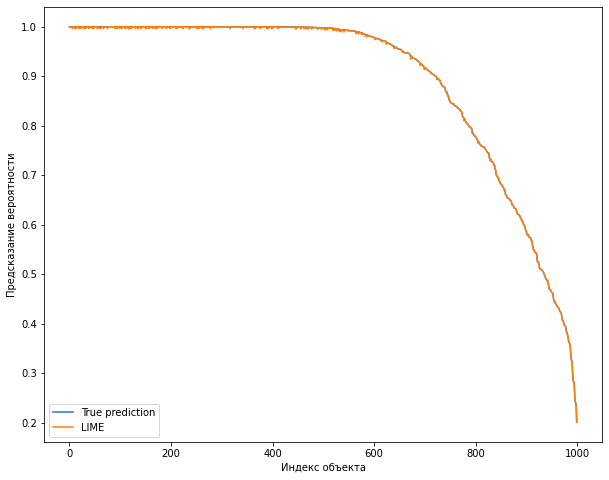

In [370]:
li = [true_lime[i][1] for i in range(sample_size)]
tr = [true_lime[i][0] for i in range(sample_size)]
fig = plt.figure(figsize=(10, 8))
plt.plot(tr, label='True prediction')
plt.plot(li, label='LIME')
plt.xlabel('Индекс объекта')
plt.ylabel('Предсказание вероятности')
plt.legend(loc=3)
fig.axes[0].set_rasterized(True)
plt.show()